In [1]:
import sys
sys.path.insert(0,'../code')

In [2]:
import torch
import torch.nn.functional as F
import numpy as np
from datamodules.transformations import UnNest
from transformers import ViTFeatureExtractor, ViTForImageClassification
from tqdm.auto import tqdm
from datamodules.image_classification import CIFAR10DataModule
from models.interpretation import ImageInterpretationNet
from utils.getters_setters import vit_getter, vit_setter
from attributions.grad_cam import grad_cam
from attributions.attention_rollout import attention_rollout
from attributions.chefer import chefer_attributions
from utils.plot import smoothen
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt

/home/angelos/anaconda3/envs/dl2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load CIFAR-10 Test Split and Model

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

vit = ViTForImageClassification.from_pretrained("tanlq/vit-base-patch16-224-in21k-finetuned-cifar10").to(device)

diffmask = ImageInterpretationNet.load_from_checkpoint('../checkpoints/diffmask.ckpt').to(device)

feature_extractor=ViTFeatureExtractor.from_pretrained(
    "tanlq/vit-base-patch16-224-in21k-finetuned-cifar10", return_tensors="pt"
)
feature_extractor = UnNest(feature_extractor)

batch_size = 4

dm = CIFAR10DataModule(feature_extractor=feature_extractor, batch_size=batch_size)
dm.prepare_data()
dm.setup('test')
dataloader = dm.test_dataloader()

Files already downloaded and verified
Files already downloaded and verified


# AUC

### Function to measure area under curve (AUC). 

In [ ]:
def unravel_index(index, shape):
        out = []
        for dim in reversed(shape):
            out.append(index % dim)
            index = torch.div(index, dim, rounding_mode='trunc')
        return tuple(reversed(out))

def auc(model, input, labels, attributions, positive=True, k=0.2, num_tokens=1):
    area = []
    B, H, W = attributions.shape
    attributions = attributions.reshape(B, -1)
    # Get hidden states from unmasked input
    logits_orig, hidden_states = vit_getter(model, input)
    probs_orig = logits_orig.softmax(-1)
    if not labels:
        labels = probs_orig.argmax(-1)

    drop_k = int(k * attributions.shape[1])

    for i in range(0, drop_k + 1, 256 * num_tokens):
        keep_k = attributions.shape[1] - i
        idx = attributions.topk(keep_k, dim=1, largest=(not positive)).indices.sort()[0].squeeze(-1)

        torch.manual_seed(123)
        f = torch.rand((B, input.shape[1], H, W), device=device)*2 - 1 # Baseline pixels
        for i in range(B):
            idx_i = idx[i]
            unraveled_idx = unravel_index(idx_i, (H, W))
            f[i, :, unraveled_idx[0], unraveled_idx[1]] = input[i, :, unraveled_idx[0], unraveled_idx[1]]

        # Forward pass through the model to get the logits
        logits, hidden_states = vit_getter(model, f)
        probs = logits.softmax(-1)

        area.append(probs[range(B), labels].mean().item())

    return area

def calculate_auc(positive=True, method='diffmask'):
    auc_positive = []
    for i, (images, labels) in tqdm(enumerate(dataloader), total=50):
        if i == 50: break
#         images, labels = images.cuda(), labels.cuda()
        if method == 'diffmask':
            attributions = diffmask.get_mask(images)["mask"].detach()
        elif method == 'rollout':
            attributions = attention_rollout(images=images, vit=vit, device=device)
        elif method == 'gradcam':
            images.requires_grad = True
            attributions = grad_cam(images, vit, True if device=='cuda' else False)
        elif method == 'chefer':
            images.requires_grad = True
            attributions = torch.stack([chefer_attributions(vit.cpu(), img) for img in images])
        comp = auc(vit.cpu(), images.cpu(), None, attributions.cpu(), num_tokens=7, k=1, positive=positive)
        auc_positive.append(comp)
    return auc_positive

auc_pos_chefer = np.asarray(calculate_auc(positive=True, method='chefer')).mean(0)
auc_neg_chefer = np.asarray(calculate_auc(positive=False, method='chefer')).mean(0)

  2%|▉                                           | 1/50 [00:16<13:26, 16.46s/it]

### AUC for Grad-CAM

In [6]:
auc_pos_gradcam = np.asarray(calculate_auc(positive=True, method='gradcam')).mean(0)
auc_neg_gradcam = np.asarray(calculate_auc(positive=False, method='gradcam')).mean(0)

100%|███████████████████████████████████████████| 50/50 [01:19<00:00,  1.60s/it]


### AUC for DiffMask

In [7]:
diffmask.set_vision_transformer(vit)

auc_pos_diffmask = np.asarray(calculate_auc(positive=True)).mean(0)
auc_neg_diffmask = np.asarray(calculate_auc(positive=False)).mean(0)

100%|███████████████████████████████████████████| 50/50 [00:42<00:00,  1.17it/s]


### AUC for Attention-Rollout

In [8]:
auc_pos_rollout = np.asarray(calculate_auc(positive=True, method='rollout')).mean(0)
auc_neg_rollout = np.asarray(calculate_auc(positive=False, method='rollout')).mean(0)

100%|███████████████████████████████████████████| 50/50 [00:41<00:00,  1.20it/s]


In [15]:
auc_pos_chefer = np.asarray(calculate_auc(positive=True, method='chefer')).mean(0)
auc_neg_chefer = np.asarray(calculate_auc(positive=False, method='chefer')).mean(0)

  0%|                                                    | 0/50 [00:00<?, ?it/s]


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

### Plot AUC

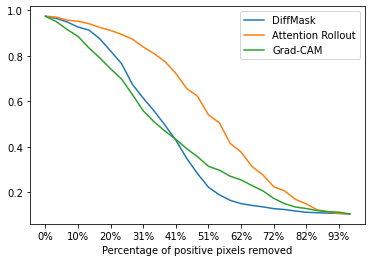

In [8]:
plt.plot(auc_pos_diffmask, label="DiffMask")
plt.plot(auc_pos_rollout, label="Attention Rollout")
plt.plot(auc_pos_gradcam, label="Grad-CAM")
plt.plot(auc_pos_chefer, label="Chefer et al.")
plt.xlabel("Percentage of positive pixels removed")
len_x = len(auc_pos_diffmask)
x_ticks = np.arange(0, len_x, 3)
x_ticks_labels = [str(int(x * 100 / len_x)) + "%" for x in x_ticks]
plt.xticks(x_ticks, x_ticks_labels)
plt.legend()
plt.show()

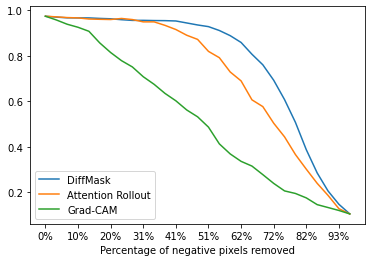

In [9]:
plt.clf()
plt.plot(auc_neg_diffmask, label="DiffMask")
plt.plot(auc_neg_rollout, label="Attention Rollout")
plt.plot(auc_neg_gradcam, label="Grad-CAM")
plt.plot(auc_neg_chefer, label="Chefer et al.")
len_x = len(auc_neg_diffmask)
x_ticks = np.arange(0, len_x, 3)
x_ticks_labels = [str(int(x * 100 / len_x)) + "%" for x in x_ticks]
plt.xticks(x_ticks, x_ticks_labels)
plt.xlabel("Percentage of negative pixels removed")
plt.legend()
plt.show()

# Accuracy and KL-Divergence

### Function to measure KL-divergence and Accuracy between masked & unmasked input

In [ ]:
@torch.no_grad()
def get_kld_and_acc(model, input, labels, mask, b, n_hidden=14, patch_size=16):
    # Reshape mask to hidden states' shape
    B, H, W = mask.shape
    mask = mask.reshape(B, 1, H, W)
    mask = F.interpolate(mask, scale_factor=1/patch_size)
    mask = mask.reshape(B, -1, 1)
    
    # Get hidden states from unmasked input
    logits_orig, hidden_states = vit_getter(model, input)
    
    # Calculate hidden states from masked input
    new_hidden_states = hidden_states[0] * mask + b * (1 - mask)
    new_hidden_states = [new_hidden_states] + [None] * (n_hidden - 1)
    
    # Append CLS token
    cls_tokens = model.vit.embeddings.cls_token.expand(B, -1, -1)
    new_hidden_states[0] = torch.cat((cls_tokens, new_hidden_states[0]), dim=1)

    # Get logits from new hidden states (masked input)
    logits, _ = vit_setter(model, input, new_hidden_states)
    
    pred_class = logits.argmax(-1)
    acc = pred_class == labels

    # Compute KL divergence between the logits from the original and the masked input
    kl_div = torch.distributions.kl_divergence(
                torch.distributions.Categorical(logits=logits_orig),
                torch.distributions.Categorical(logits=logits),
            )
    
    return kl_div, acc

### KL-Divergence and Accuracy for Grad-CAM

In [ ]:
klds = []
accs = []
masks_percentage = []

for images, labels in tqdm(dataloader):
    images, labels = images.cuda(), labels.cuda()
    gradcam_masks = grad_cam(images, vit, True if device=='cuda' else False)
    masked_pixels_percentages = [100 * (1 - mask.mean(-1).mean(-1).item()) for mask in gradcam_masks]
    kld, acc = get_kld_and_acc(vit, images, labels, gradcam_masks.cuda(), diffmask.gate.placeholder)
    klds.append(kld)
    accs.append(acc)
    masks_percentage.extend(masked_pixels_percentages)

    
klds = torch.cat(klds)
accs = torch.cat(accs)
print(f"Grad-CAM mean KL-Divergence: {klds.mean()}")
print(f"Grad-CAM accuracy: {torch.sum(accs)/ len(accs)}")
print(f"Masking percentage: {np.mean(masks_percentage)}")

### KL-Divergence and Accuracy for Attention Rollout

In [ ]:
klds = []
accs = []
masks_percentage = []

for images, labels in tqdm(dataloader):
    images, labels = images.cuda(), labels.cuda()
    rollout_masks = attention_rollout(images=images, vit=vit, device=device)
    masked_pixels_percentages = [100 * (1 - mask.mean(-1).mean(-1).item()) for mask in rollout_masks]
    kld, acc = get_kld_and_acc(vit, images, labels, rollout_masks, diffmask.gate.placeholder)
    klds.append(kld)
    accs.append(acc)
    masks_percentage.extend(masked_pixels_percentages)

    
klds = torch.cat(klds)
accs = torch.cat(accs)
print(f"Rollout mean KL-Divergence: {klds.mean()}")
print(f"Rollout accuracy: {torch.sum(accs)/ len(accs)}")
print(f"Masking percentage: {np.mean(masks_percentage)}")

### KL-Divergence and Accuracy for DiffMask

In [ ]:
diffmask.set_vision_transformer(vit)

klds = []
accs = []
masks_percentage = []

for i, (images, labels) in enumerate(tqdm(dataloader)):
    if i == 10: break
    images, labels = images.cuda(), labels.cuda()
    diff_masks = diffmask.get_mask(images)["mask"].detach()
    masked_pixels_percentages = [100 * (1 - mask.mean(-1).mean(-1).item()) for mask in diff_masks]
    kld, acc = get_kld_and_acc(vit, images, labels, diff_masks, diffmask.gate.placeholder)
    klds.append(kld)
    accs.append(acc)
    masks_percentage.extend(masked_pixels_percentages)

klds = torch.cat(klds)
accs = torch.cat(accs)
print(f"Diffmask mean KL-Divergence: {klds.mean()}")
print(f"Diffmask accuracy: {torch.sum(accs)/ len(accs)}")
print(f"Masking percentage: {np.mean(masks_percentage)}")